<a href="https://colab.research.google.com/github/Lidiia-Afanasieva/ISSvsSteven/blob/main/ISSvsSteven.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
pip install multipledispatch

ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools


In [53]:
# TensorFlow and tf.keras
import tensorflow as tf
from PIL import Image
import os
from urllib.request import urlopen
import io
import seaborn as sns
import random

# Helper libraries
from IPython.core.pylabtools import figsize
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import seaborn as sn

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from multipledispatch import dispatch
import itertools
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from urllib.error import HTTPError
import sys

In [71]:
def classification_report(y_true, y_pred, labels=None, 
                          target_names=['Not Pumpyy pooo', 'Pumpy pooo'],
                          sample_weight=None, digits=4, tablfmt='pipe'):
    """  Better format for sklearn's classification report
    Based on tabulate package
    ----------
    y_true : 1d array-like, or label indicator array / sparse matrix
        Ground truth (correct) target values.
    y_pred : 1d array-like, or label indicator array / sparse matrix
        Estimated targets as returned by a classifier.
    labels : array, shape = [n_labels]
        Optional list of label indices to include in the report.
    target_names : list of strings
        Optional display names matching the labels (same order).
    sample_weight : array-like of shape = [n_samples], optional
        Sample weights.
    digits : int
        Number of digits for formatting output floating point values
    Returns
    -------
    report : string
        Text summary of the precision, recall, F1 score for each class.
        The reported averages are a prevalence-weighted macro-average across
        classes (equivalent to :func:`precision_recall_fscore_support` with
        ``average='weighted'``).
        Note that in binary classification, recall of the positive class
        is also known as "sensitivity"; recall of the negative class is
        "specificity".
    Examples
    --------
    >>> from sklearn.metrics import classification_report
    >>> y_true = [0, 1, 2, 2, 2]
    >>> y_pred = [0, 0, 2, 2, 1]
    >>> target_names = ['class 0', 'class 1', 'class 2']
    >>> print(classification_report(y_true, y_pred, target_names=target_names))
                 precision    recall  f1-score   support
    """
    floatfmt = '.{:}f'.format(digits)
    if labels is None:
        labels = unique_labels(y_true, y_pred)
    else:
        labels = np.asarray(labels)

    if target_names is not None and len(labels) != len(target_names):
        print(
            "labels size, {0}, does not match size of target_names, {1}"
            .format(len(labels), len(target_names))
        )

    last_line_heading = 'avg / total'

    if target_names is None:
        target_names = [u'%s' % l for l in labels]

    headers = ["precision", "recall", "f1-score", "support"]

    p, r, f1, s = precision_recall_fscore_support(y_true, y_pred,
                                                  labels=labels,
                                                  average=None,
                                                  sample_weight=sample_weight)

    rows = zip(target_names, p, r, f1, s)
    tbl_rows = []
    for row in rows:
        tbl_rows.append(row)

    # compute averages
    last_row = (last_line_heading,
                np.average(p, weights=s),
                np.average(r, weights=s),
                np.average(f1, weights=s),
                np.sum(s))
    tbl_rows.append(last_row)
    return tabulate(tbl_rows, headers=headers,
                    tablefmt=tablfmt, floatfmt=floatfmt)

In [5]:
# TO SHOW IMAGE

@dispatch(list)
def magick(steeevaaa):
    global classes
    
    plt.figure(figsize=(8,8))
    plt.imshow(steeevaaa[0])
    plt.axis('off')

In [6]:
# TO SHOW IMAGES PAIR

@dispatch(list, list)
def magick(steeevaaa, issaaaa):
    global classes
    
    plt.figure(figsize=(8,8))

    for j, i in enumerate([steeevaaa, issaaaa]):
        plt.subplot(1, 2, j + 1)
        plt.title(classes[i[1]])
        plt.imshow(i[0])
        plt.axis('off')

In [7]:
# TO DOWNLOAD DATASET AND CHANGE SIZE

def download_set(data_path, class_name):
    global img_size
    only_img_list = []

    for img in os.listdir(data_path):
        img_arr =  cv2.imread(os.path.join(data_path, str(img)))
        # color channel conversion and circumcision))
        img_arr = cv2.cvtColor(cv2.resize(img_arr, dsize=(img_size, img_size)), cv2.COLOR_BGR2RGB)
        only_img_list.append(img_arr)

    return only_img_list

In [6]:
img_size = 8

/content/drive/MyDrive/steven/Стивен из вселенной Стивена и международная космическая станция/MKC
602 0
/content/drive/MyDrive/steven/Стивен из вселенной Стивена и международная космическая станция/Стивен из вселенной Стивена
520 1


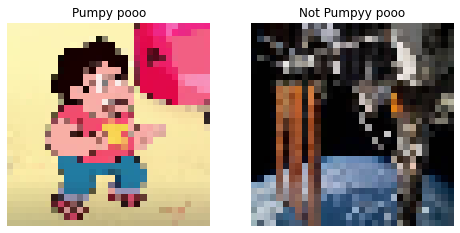

In [8]:
# FULL DATASET

full_ISS_dir = "/content/drive/MyDrive/steven/Стивен из вселенной Стивена и международная космическая станция/MKC"  # 602
full_Steven_dir = "/content/drive/MyDrive/steven/Стивен из вселенной Стивена и международная космическая станция/Стивен из вселенной Стивена"  # 520

directory = [full_ISS_dir, full_Steven_dir]

classes = ['Not Pumpyy pooo', 'Pumpy pooo']

full_img_list = []
full_base = []

img_size = 32

train_base = []
test_base = []
temp_arr = []

only_img_list_tr = []
only_img_list_tt = []

for d_set_path in directory:
    print(d_set_path)  # debag
    os.chdir(d_set_path)
    current_class = 0 if '/MKC' in d_set_path else 1
    full_img_list.extend(download_set(os.getcwd(), current_class))
    temp_arr = download_set(os.getcwd(), current_class)
    print(len(temp_arr), current_class)  # debag
    full_base.extend([[i, current_class] for i in temp_arr])

magick(full_base[800], full_base[4])

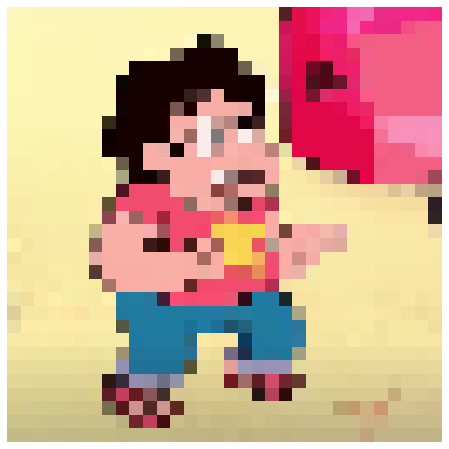

In [9]:
magick(full_base[800])
# plt.savefig("/content/drive/MyDrive/CoolSteven.png")

In [ ]:
print(type(full_base[0][0]))

<class 'numpy.ndarray'>


In [10]:
# BUILDING A RIGHT ARRAY MODE

random.shuffle(full_base)

x_full = []
y_full = []

x_train = []
y_train = []

x_test = []
y_test = []

for img, cls in full_base:
    x_full.append(img)
    y_full.append(cls)

x_train, x_test, y_train, y_test = train_test_split(x_full, y_full, test_size=0.2, random_state=42, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, shuffle=True)

x_train = np.array(x_train)
x_test = np.array(x_test)

x_train = x_train.reshape(-1, img_size, img_size, 3)
x_train = x_train/255

x_test = x_test.reshape(-1, img_size, img_size, 3)
x_test = x_test/255

print(f'x_train shape is : {x_train.shape}')  # debag
print(f'x_test shape is : {x_test.shape}')  # debag

y_train = to_categorical(y_train, num_classes=2)
print(f'y_train shape is : {y_train.shape}')  # debag

y_test = to_categorical(y_test, num_classes = 2)

x_train shape is : (717, 32, 32, 3)
x_test shape is : (225, 32, 32, 3)
y_train shape is : (717, 2)


In [13]:
# THE COOOOLEST CODE IN THE WORLD
# COUSE ITS WORKING
# ACTUALLY ITS BUILD NN ARCHITECTURE AND OPTIMISE IT WITH ADAM

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, shuffle=True)
print(f'x_train is : {len(x_train)}')  # debag
print(f'x_val is : {len(x_val)}')  # debag
print(f'y_train is : {len(y_train)}')  # debag
print(f'y_val is : {len(y_val)}')  # debag

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(img_size, img_size,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

optimizer=Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 10
batch_size = 32
datagen = ImageDataGenerator(featurewise_center=False, 
                             samplewise_center=False, 
                             featurewise_std_normalization=False, 
                             samplewise_std_normalization=False, 
                             zca_whitening=False, 
                             zca_epsilon=0.000001, 
                             rotation_range=0.5, 
                             width_shift_range=0, 
                             height_shift_range=0, 
                             brightness_range=None, 
                             shear_range=0, 
                             zoom_range=0.5, 
                             channel_shift_range=0, 
                             fill_mode='nearest', 
                             cval=0, 
                             horizontal_flip=False, 
                             vertical_flip=False)

datagen.fit(x_train)
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs, steps_per_epoch=x_train.shape[0]//batch_size)

x_train is : 366
x_val is : 92
y_train is : 366
y_val is : 92
Epoch 1/10
11/11 [==============================] - 1s 44ms/step - loss: 0.7875 - accuracy: 0.6018
Epoch 2/10
11/11 [==============================] - 0s 41ms/step - loss: 0.4765 - accuracy: 0.7695
Epoch 3/10
11/11 [==============================] - 0s 42ms/step - loss: 0.3361 - accuracy: 0.8443
Epoch 4/10
11/11 [==============================] - 0s 43ms/step - loss: 0.2276 - accuracy: 0.9102
Epoch 5/10
11/11 [==============================] - 0s 45ms/step - loss: 0.1562 - accuracy: 0.9641
Epoch 6/10
11/11 [==============================] - 0s 42ms/step - loss: 0.1233 - accuracy: 0.9551
Epoch 7/10
11/11 [==============================] - 0s 42ms/step - loss: 0.1369 - accuracy: 0.9491
Epoch 8/10
11/11 [==============================] - 0s 41ms/step - loss: 0.1019 - accuracy: 0.9611
Epoch 9/10
11/11 [==============================] - 0s 43ms/step - loss: 0.0863 - accuracy: 0.9760
Epoch 10/10
11/11 [============================

In [ ]:
# NOT THE COOOOLEST CODE IN THE WORLD

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, shuffle=True)
print(f'x_train is : {len(x_train)}')  # debag
print(f'x_val is : {len(x_val)}')  # debag
print(f'y_train is : {len(y_train)}')  # debag
print(f'y_val is : {len(y_val)}')  # debag

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='Same', activation='relu', input_shape=(img_size, img_size,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(32))
model.add(Dense(32))
model.add(Dense(2, activation='softmax'))

optimizer=Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 15
batch_size = 32
datagen = ImageDataGenerator(featurewise_center=False, 
                             samplewise_center=False, 
                             featurewise_std_normalization=False, 
                             samplewise_std_normalization=False, 
                             zca_whitening=False, 
                             zca_epsilon=0.000001, 
                             rotation_range=0.5, 
                             width_shift_range=0, 
                             height_shift_range=0, 
                             brightness_range=None, 
                             shear_range=0, 
                             zoom_range=0.5, 
                             channel_shift_range=0, 
                             fill_mode='nearest', 
                             cval=0, 
                             horizontal_flip=False, 
                             vertical_flip=False)

datagen.fit(x_train)
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs, steps_per_epoch=x_train.shape[0]//batch_size)

|                 |   precision |   recall |   f1-score |   support |
|:----------------|------------:|---------:|-----------:|----------:|
| Not Pumpyy pooo |      0.9800 |   0.9608 |     0.9703 |   51.0000 |
| Pumpy pooo      |      0.9524 |   0.9756 |     0.9639 |   41.0000 |
| avg / total     |      0.9677 |   0.9674 |     0.9674 |   92.0000 |


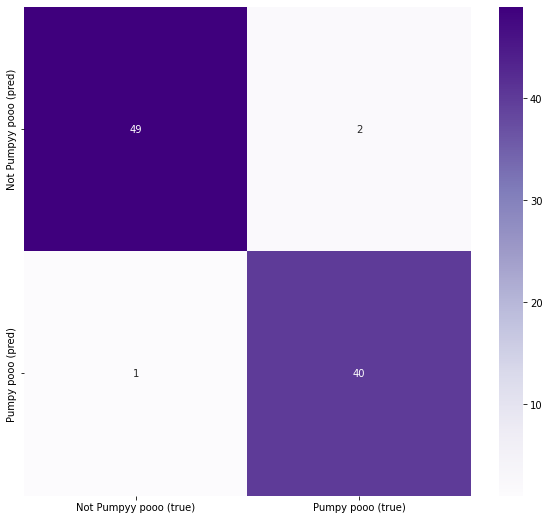

In [73]:
# CONTROL VALIDATION

from google.colab import data_table

y_pred = model.predict(x_val)
y_pred_cls = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)
conf_mat = confusion_matrix(y_true, y_pred_cls)
data_table.enable_dataframe_formatter()
print(classification_report(y_true, y_pred_cls))
f, ax = plt.subplots(figsize=(10, 9))
sns.heatmap(conf_mat, annot=True, fmt='.0f', cmap='Purples')
ax.set_xticklabels([item + ' (true)' for item in classes])
ax.set_yticklabels([item + ' (pred)' for item in classes])
# df_cm = pd.DataFrame(array, index = [item + ' (true)' for item in classes], columns = [item + ' (pred)' for item in classes])
# sn.heatmap(df_cm, annot=True,cmap="OrRd")
plt.show()

|                 |   precision |   recall |   f1-score |   support |
|:----------------|------------:|---------:|-----------:|----------:|
| Not Pumpyy pooo |      0.9841 |   0.9841 |     0.9841 |  126.0000 |
| Pumpy pooo      |      0.9798 |   0.9798 |     0.9798 |   99.0000 |
| avg / total     |      0.9822 |   0.9822 |     0.9822 |  225.0000 |


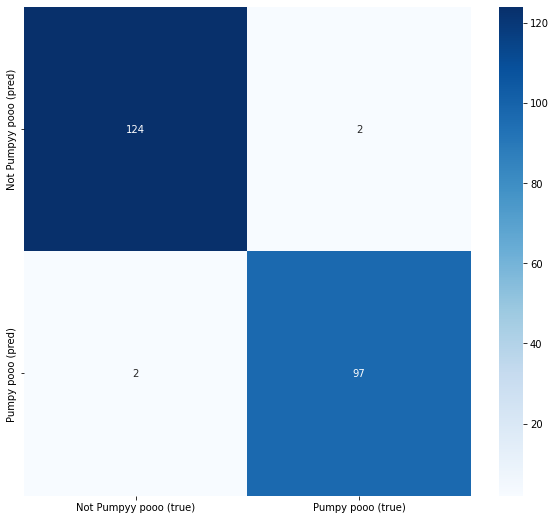

In [74]:
# TEST

y_pred2 = model.predict(x_test)
y_pred_cls2 = np.argmax(y_pred2, axis=1)
y_true2 = np.argmax(y_test, axis=1)
conf_mat2 = confusion_matrix(y_true2, y_pred_cls2)
print(classification_report(y_true2, y_pred_cls2))
f, ax = plt.subplots(figsize=(10, 9))
sns.heatmap(conf_mat2, annot=True, fmt='.0f', cmap='Blues')
ax.set_xticklabels([item + ' (true)' for item in classes])
ax.set_yticklabels([item + ' (pred)' for item in classes])
plt.show()

In [ ]:
# os.remove('/content/drive/MyDrive/steven/Стивен из вселенной Стивена и международная космическая станция/Стивен из вселенной Стивена/Screenshot_520.png')

In [44]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils.multiclass import unique_labels
import numpy as np
from tabulate import tabulate


Predict: its Pumpy pooo
Probability is: 99.83300018310547%


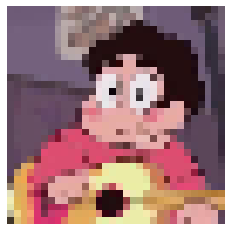

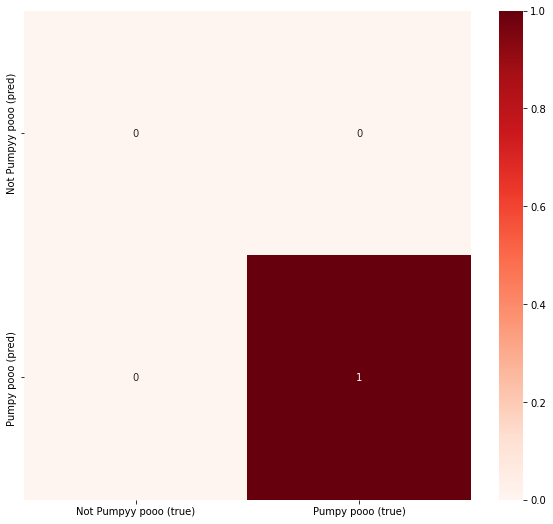

[[0.0016725  0.99832755]]


In [69]:
# URL IMAGE WORK

# Pumpy pooo
# https://c-cl.cdn.smule.com/rs-s87/arr/f8/65/e4b2a575-fbf4-4611-8f10-643c4b94bac6.jpg
# https://media.myshows.me/shows/1920/c/19/c19d86c712121a60f9ad75979d5860f7.jpg
# https://slovnet.ru/wp-content/uploads/2018/08/1-29.jpg  # dark bg

# Not Pumpyy pooo
# https://cdni.russiatoday.com/rbthmedia/images/2020.12/article/5feb853a85600a4a470fb151.jpg 


def get_check():
    global img_size

    fd = urlopen("https://c-cl.cdn.smule.com/rs-s87/arr/f8/65/e4b2a575-fbf4-4611-8f10-643c4b94bac6.jpg")

    # print(type(fd))  # debag
    image_file = io.BytesIO(fd.read())
    img = Image.open(image_file)
    img_arr = np.array(img)
    img_arr[20,30]
    plt.axis('off')
    # 

    # print(img_arr.shape)  # debag

    img_arr = cv2.resize(img_arr, dsize=(img_size, img_size))

    # print(img_arr.shape)  # debag
    # print(img_arr[0])  # debag
    plt.imshow(img_arr)  # debag
    
    # plt.savefig("/content/drive/MyDrive/steven/Стивен из вселенной Стивена и международная космическая станция/Стивен из вселенной Стивена/Screenshot_520.png")


    img_arr = img_arr.reshape(-1, img_size, img_size, 3)
    img_arr = img_arr/255

    # print(img_arr.shape)  # debag
    # print(img_arr[0])  # debag
    return img_arr


true = 'Steven'
# true = 'ISS'

y_pred = model.predict(get_check())
y_pred_cls = np.argmax(y_pred, axis=1)

if true == 'Steven':
    y_true = [1] 
elif true == 'ISS':
    y_true = [0]
if y_true == y_pred_cls:
    print(f'Predict: its {classes[y_pred_cls[0]]}')
    print(f'Probability is: {round(np.amax([item * 100 for item in y_pred]), 3)}%')
else:
    print(f'Error. Its not {true}')
    print("y_pred = ", y_pred * 100)

# print(classification_report(y_true, y_pred_cls))
conf_mat = confusion_matrix(y_true, y_pred_cls, labels=[0, 1])
f, ax = plt.subplots(figsize=(10, 9))
sns.heatmap(conf_mat, annot=True, fmt='.0f', cmap='Reds')
ax.set_xticklabels([item + ' (true)' for item in classes])
ax.set_yticklabels([item + ' (pred)' for item in classes])
plt.show()